In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
from tqdm import tqdm, trange

In [2]:
experiment = 'CCAT-prime'

In [3]:
from LIMxCMBL.experiments import *

In [4]:
zmin = experiments[experiment]['zmin']
zmax = experiments[experiment]['zmax']
line_str = experiments[experiment]['line_str']

Omega_field  =  experiments[experiment]['Omega_field']
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

In [5]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [6]:
import matplotlib.pyplot as plt

In [7]:
def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
    
    oup = np.zeros((100, n_bins, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
        for j, (l2, r2) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            idx2 = np.where((external_chis > l2) & (external_chis <= r2))[0]
            oup[:,i,j] = (np.sum(base[:,
                                      idx1[0]:idx1[-1]+1,
                                      idx2[0]:idx2[-1]+1], 
                                 axis=(1, 2)) / len(idx1) / len(idx2))
    return oup

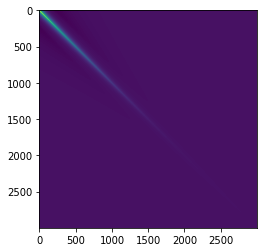

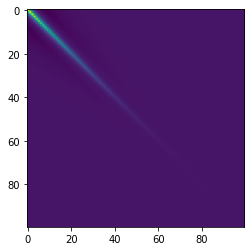

In [8]:
#get <II>
I_I_unbinned = np.load('/scratch/users/delon/LIMxCMBL/I_auto/'+
                          'I_auto_n_ext_%d_zmin_%.1f_zmax_%.1f.npy'%(3000, 
                                                                     zmin, 
                                                                     zmax))

plt.imshow(I_I_unbinned[0])
plt.show()
I_I = get_binned(I_I_unbinned, n_external = 3000)
plt.imshow(I_I[0])

100%|██████████| 100/100 [00:02<00:00, 40.57it/s]


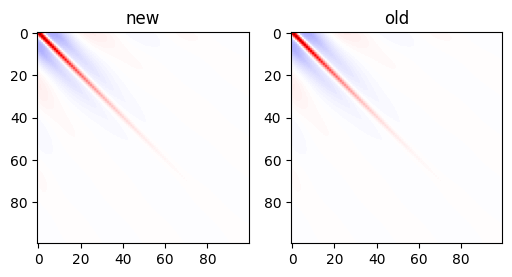

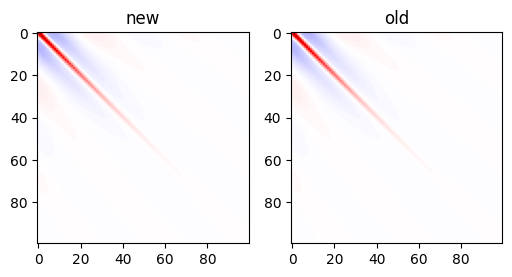

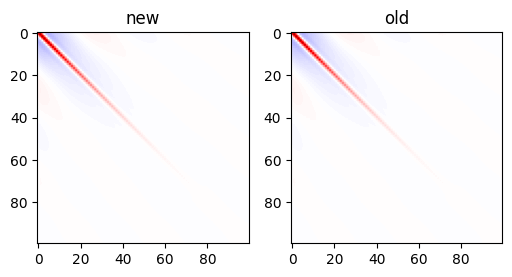

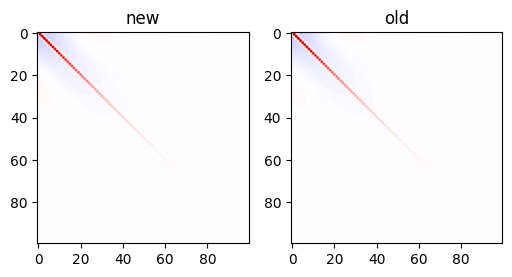

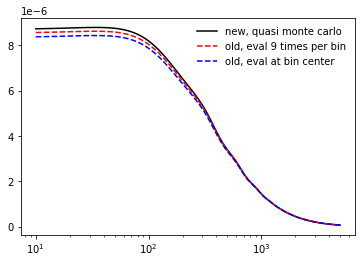

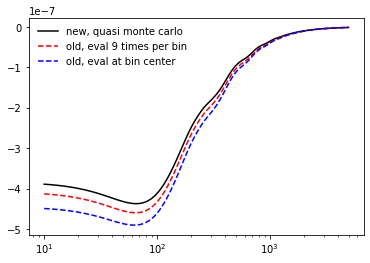

100%|██████████| 100/100 [00:02<00:00, 41.06it/s]


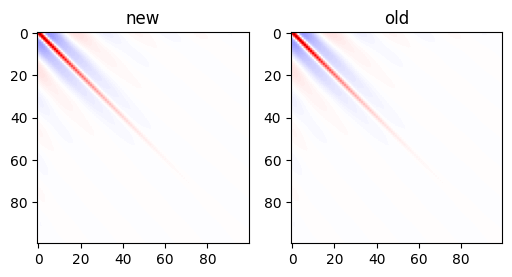

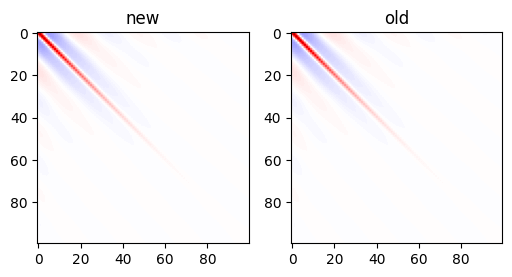

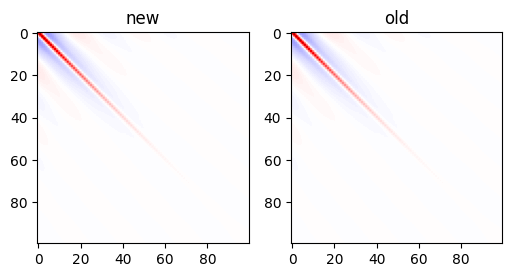

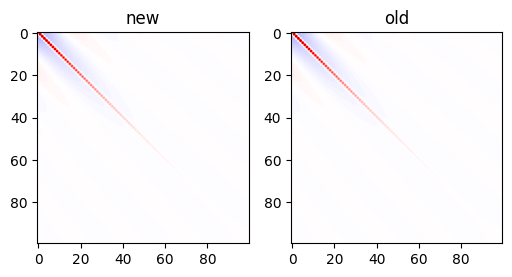

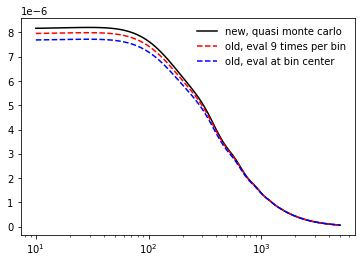

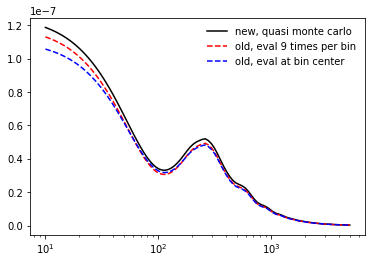

100%|██████████| 100/100 [00:02<00:00, 40.74it/s]


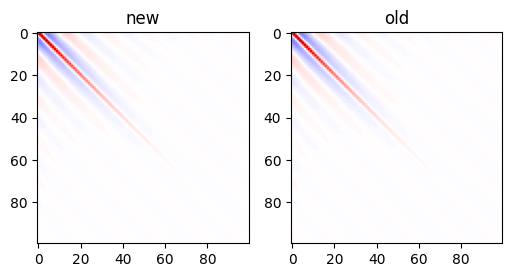

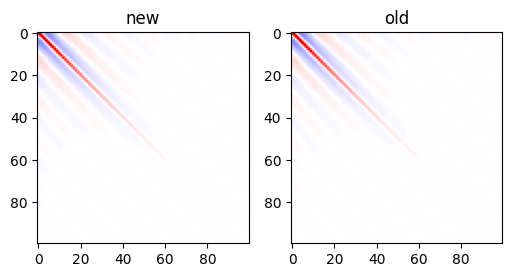

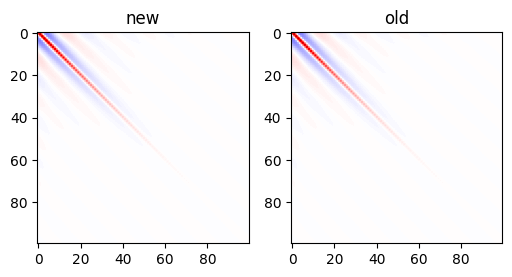

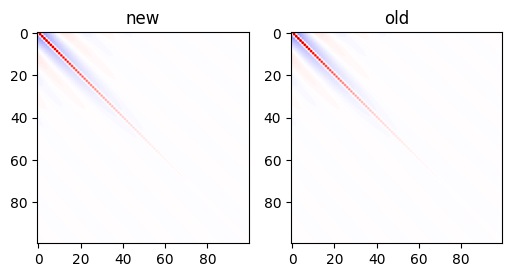

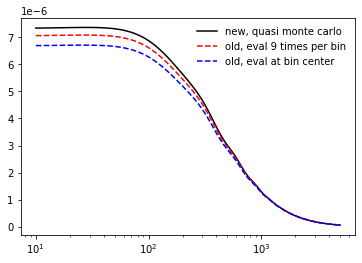

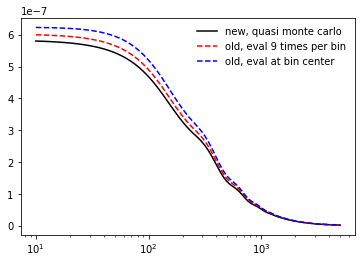

100%|██████████| 100/100 [00:02<00:00, 39.63it/s]


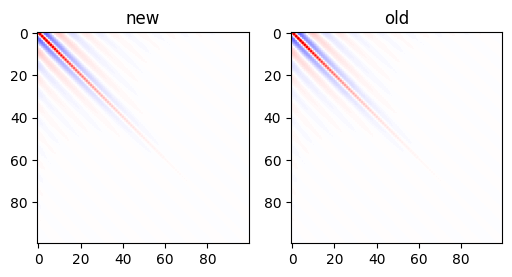

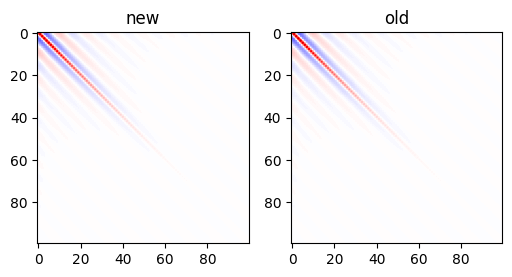

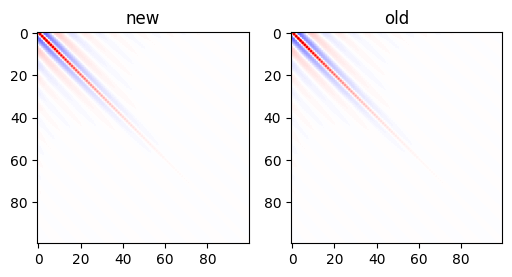

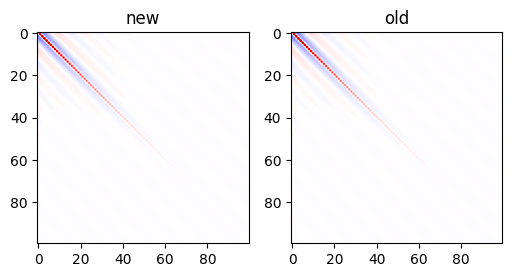

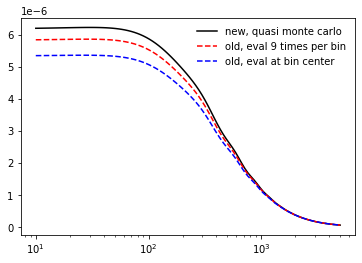

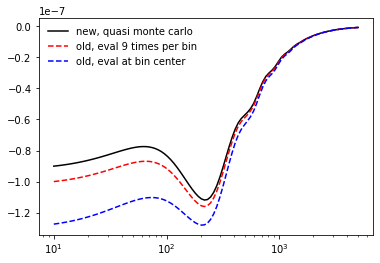

100%|██████████| 100/100 [00:02<00:00, 38.65it/s]


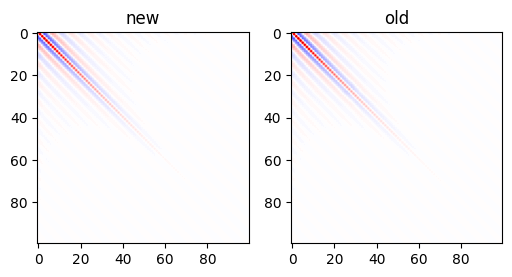

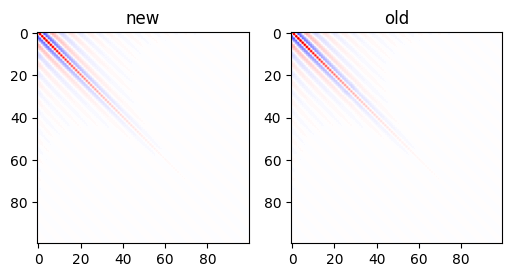

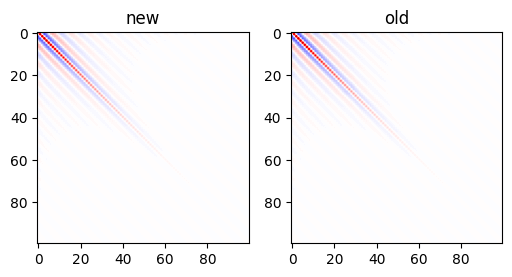

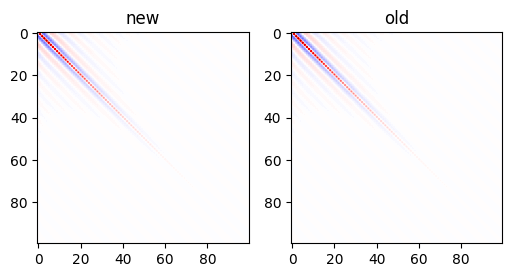

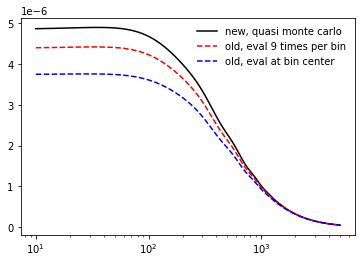

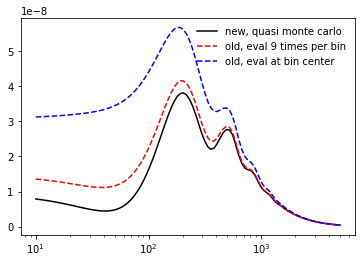

100%|██████████| 100/100 [00:02<00:00, 41.19it/s]


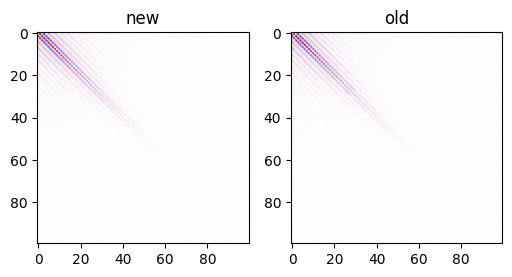

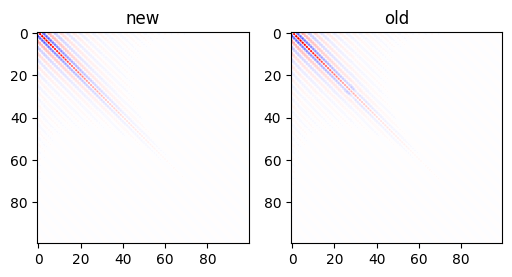

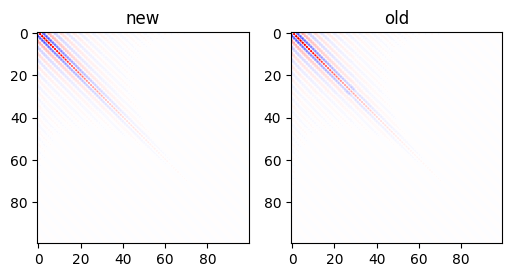

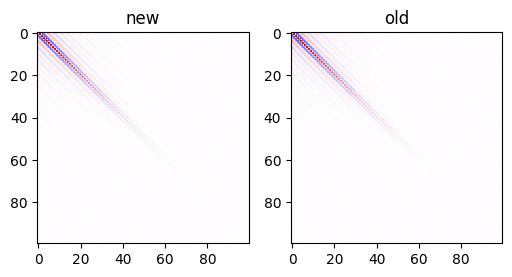

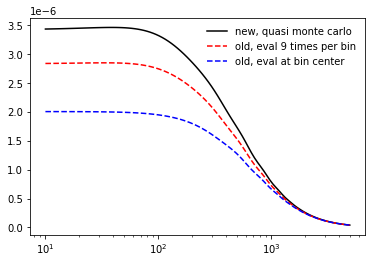

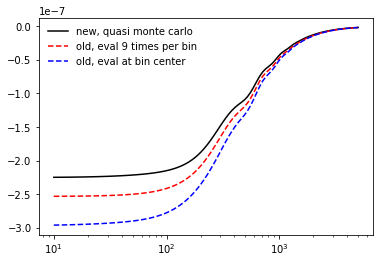

100%|██████████| 100/100 [00:02<00:00, 40.97it/s]


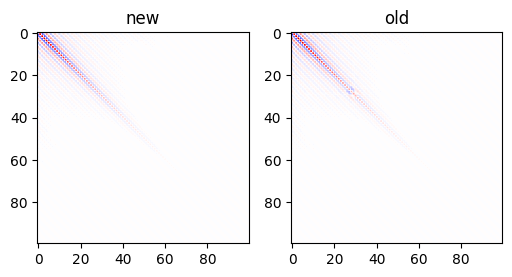

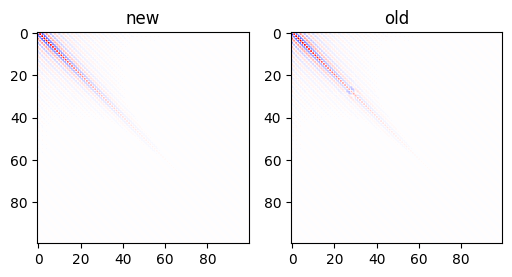

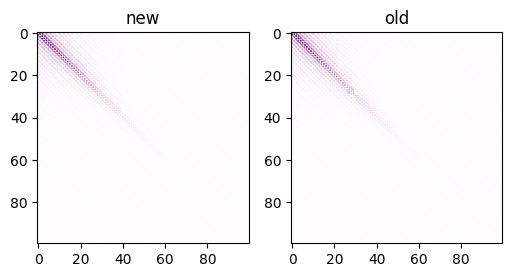

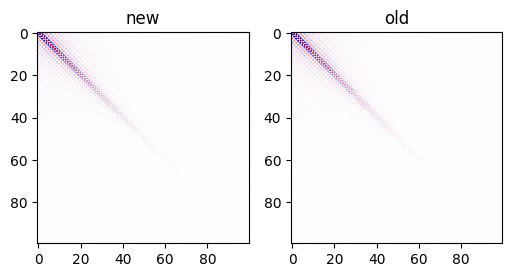

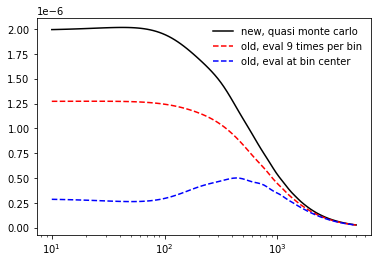

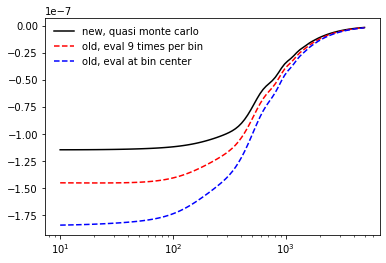

100%|██████████| 100/100 [00:00<00:00, 173.71it/s]


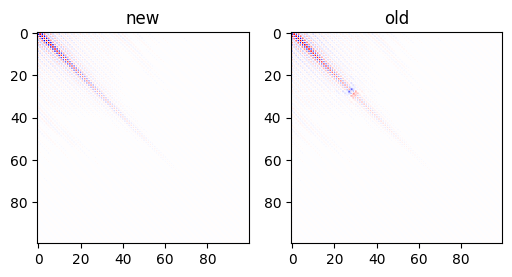

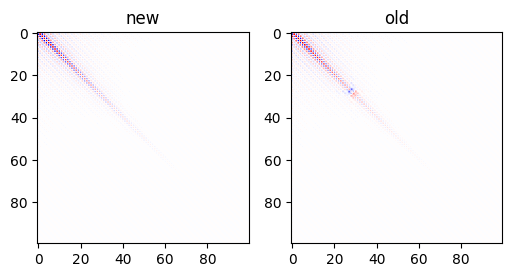

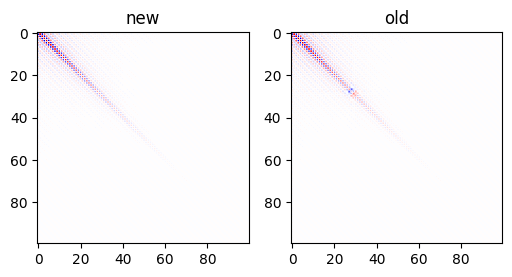

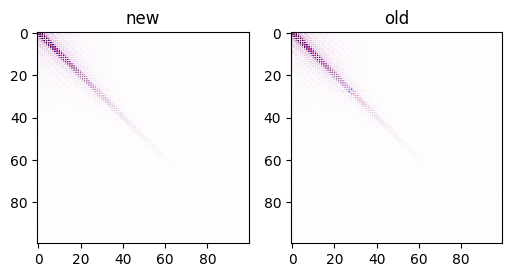

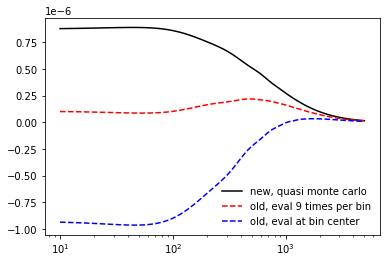

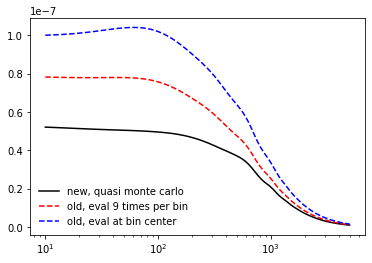

In [9]:
for Lambda_idx in range(25):
    Lambda = Lambdas[Lambda_idx]
    if(Lambda < 4* np.pi/(chimax-chimin)):
        continue
    ####################################################
    #IHi_IHi############################################
    IHiIHi = np.zeros((len(ells), n_bins, n_bins))

    for idx1 in trange(n_bins):
        for idx2 in range(idx1, n_bins):
            IHiIHi_fname = '/scratch/users/delon/LIMxCMBL/I_auto/from_s3df/%s/comb_'%(experiment)
            IHiIHi_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_b_%d_%d_%d_jax_qmc.npy'%(line_str,
                                                                                            zmin, zmax, 
                                                                                            Lambda_idx, 
                                                                                            n_bins,idx1, idx2)

            IHiIHi[:, idx1, idx2] = np.load(IHiIHi_fname)
            IHiIHi[:, idx2, idx1] = IHiIHi[:, idx1, idx2]
    ####################################################
    ####################################################
    #old IHi_IHi############################################
    ## comb = LoLo - cross
    comb_n_external = 301
    comb_unbinned = np.zeros((len(ells), comb_n_external, comb_n_external))
    for ell_idx in range(len(ells)):
        comb_fname = '/scratch/users/delon/LIMxCMBL/old_I_auto_2025-03-26/I_auto/comb_'
        comb_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_l_%d_jax_quad.npy'%(line_str,
                                                                                      zmin, zmax, 
                                                                                      Lambda_idx, 
                                                                                      comb_n_external,
                                                                                      ell_idx)


        comb_unbinned[ell_idx] = np.load(comb_fname)
    comb = get_binned(comb_unbinned, n_external = comb_n_external)
    ##IHi IHi
    oldIHiIHi = I_I + comb
    ####################################################
    #old IHi_IHi############################################
    ## comb = LoLo - cross
    comb_n_external = 101
    comb_unbinned = np.zeros((len(ells), comb_n_external, comb_n_external))
    for ell_idx in range(len(ells)):
        comb_fname = '/scratch/users/delon/LIMxCMBL/old_I_auto_2025-03-26/I_auto/comb_'
        comb_fname += '%s_zmin_%.1f_zmax_%.1f_Lambda_idx_%d_n_ext_%d_l_%d_jax_quad.npy'%(line_str,
                                                                                      zmin, zmax, 
                                                                                      Lambda_idx, 
                                                                                      comb_n_external,
                                                                                      ell_idx)


        comb_unbinned[ell_idx] = np.load(comb_fname)
    comb = get_binned(comb_unbinned, n_external = comb_n_external)
    ##IHi IHi
    oldIHiIHi2 = I_I + comb
    ######################
    
    
    for ell_idx in range(0,len(ells), 25):
        fig, axs = plt.subplots(nrows = 1, ncols = 2, dpi = 100, figsize=(6, 3))
        vb = np.max(np.abs(IHiIHi[ell_idx]))
        axs[0].imshow(IHiIHi[ell_idx],
                  vmin = -vb,
                  vmax = vb,
                  cmap = 'seismic')
        axs[0].set_title('new')
        axs[1].imshow(oldIHiIHi[ell_idx],
                  vmin = -vb,
                  vmax = vb,
                  cmap = 'seismic')
        axs[1].set_title('old')

        plt.show()
        
    plt.plot(ells, IHiIHi[:,0,0], c='k', label='new, quasi monte carlo')
    plt.plot(ells, oldIHiIHi[:,0,0], 'r--', label='old, eval 9 times per bin')
    plt.plot(ells, oldIHiIHi2[:,0,0], 'b--', label='old, eval at bin center')
    plt.legend(frameon = False)
    plt.xscale('log')
    plt.show()
    
    plt.plot(ells, IHiIHi[:,13,0], c='k', label='new, quasi monte carlo')
    plt.plot(ells, oldIHiIHi[:,13,0], 'r--', label='old, eval 9 times per bin')
    plt.plot(ells, oldIHiIHi2[:,13,0], 'b--', label='old, eval at bin center')
    plt.legend(frameon = False)
    plt.xscale('log')
    plt.show()

# to me this seems to imply the new scheme is much better since that's where the old method was converging to but the old method could only go so far because nested quad is cursed by dimensionality